# Counting syllables by Son Quoc Tran


## ***0.Settings***

In [3]:
#import all used library
import pandas as pd
import torch
import numpy as np 
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import math
import os
import time
import datetime
import matplotlib.pyplot as pyplot
from sklearn.utils import shuffle
import re

## ***1. Preparing data***
The original dataset is downloaded from [CMU Pronouncing Dictionary](https://www.kaggle.com/rtatman/cmu-pronouncing-dictionary) on Kaggle. The dictionary like this can be useful for counting syllables in a word. In this part of the project, I use python to convert the data into format that I will use in training my models; the code take in the pronunciation in the dictionary and return the number of syllables the word has, and then store all the returned value in a .csv file for dataset in training model.

### ***1.1 Importing dataset***

In [4]:
text_file = open("/content/cmudict.dict", "r")                # I use Google Colaboratory and upload the cmudict into content folder
lines = text_file.readlines()
print(len(lines))                                             # investigate the length of the dataset
text_file.close()

135010


In [5]:
print(lines[:10])                                             # investigate the pattern of the dataset

["'bout B AW1 T\n", "'cause K AH0 Z\n", "'course K AO1 R S\n", "'cuse K Y UW1 Z\n", "'em AH0 M\n", "'frisco F R IH1 S K OW0\n", "'gain G EH1 N\n", "'kay K EY1\n", "'m AH0 M\n", "'n AH0 N\n"]


### ***1.2 Preprocessing data***

In [6]:
# use pandas to preprocess the dataset 
syllable_table = pd.DataFrame(columns=['word', 'syllable_count'])

In [7]:
def have_vowels(part_of_pronunciation):
    """Count the number of syllables in the pronunciation of a word
        Parameter: 
            part_of_pronunciation: part of the pronunciation extracted from the dictionary
        Return:
            result(boolean): whether the given part of pronuncation have vowel(s)
    """ 
    vowels = ['U','E','O','A','I']
    result = any(elem in part_of_pronunciation for elem in vowels)
  
    return result

In [8]:
for line in lines:
    split_line = line.split(' ')
    if '(' in split_line[0]: 
        continue                           # a way to ingore multiple ways of spelling a word
    word = split_line[0]
    count = 0
    for i in range(1,len(split_line)):     # iterate from the first part of pronunciation to the last one
        if have_vowels(split_line[i]):
          count += 1
    df_add = pd.DataFrame([[word, count]], columns = ['word', 'syllable_count'])
    syllable_table = syllable_table.append(df_add, ignore_index=True)

In [9]:
print(syllable_table.head())               # to investigate the converted dataset

      word syllable_count
0    'bout              1
1   'cause              1
2  'course              1
3    'cuse              1
4      'em              1


In [10]:
syllable_table.to_csv('/content/syllable_dict.csv', index=False)

## ***2. Loading data for training process***

In this step, it is extremely important to shuffle the dataset. This is because the dictionary is arranged in alphabet order. If we divide the dataset into training set and validating set: about 1000 last words will be assigned into validating set. This could cause an unexpected scenario: the developed model could perform significantly bad on words beginning with 'y' or 'z' because it has never been trained to predict words like that.

This is a basic rule in training deep learning model

In [11]:
#Load data using pandas
path_to_dictionary = '/content/syllable_dict.csv'
print('Parsing the dataset .csv file...')
dictionary = pd.read_csv(path_to_dictionary)
dictionary = shuffle(dictionary)                # shuffle the dataset
print(dictionary)
print('Finished')


Parsing the dataset .csv file...
                 word  syllable_count
28467      demobilize               4
64973          lepley               2
110973        syngman               2
120747      wallboard               2
53389         hultman               2
...               ...             ...
5169          arledge               2
76434   multinational               5
47829           gyles               1
84087           pates               1
7879             barb               1

[125929 rows x 2 columns]
Finished


### ***2.1 Preprocess the loaded data***
In this step, I will:
1. load word and count into python lists and later convert intoi pytorch tensor for training.
2. modify the values of count list to prepare for the training process. 

In [12]:
words = dictionary['word']
myWords = []
for word in words:
    myWords.append(str(word).lower())
counts = dictionary['syllable_count']
myCounts =[]
for count in counts:
    myCounts.append(count * 1000)                # this would hlep us heavily penalize the error of the model 
myCounts = np.array(myCounts)                    # convert myCounts into np.array

### ***2.2 Prepare data for training model***

In [13]:
all_words = ' '.join(str(myWords))
chars = all_words.split()
counters = Counter(chars)
char_list = sorted(counters, key=counters.get, reverse=True)
char_to_int = {char: ii for ii, char in enumerate(char_list, 1)}
print(char_to_int)

words_ints =[]
for word in myWords:
    words_ints.append([char_to_int[char] for char in str(word)])

{"'": 1, ',': 2, 'e': 3, 'a': 4, 'r': 5, 'i': 6, 's': 7, 'n': 8, 'o': 9, 't': 10, 'l': 11, 'c': 12, 'd': 13, 'm': 14, 'u': 15, 'h': 16, 'g': 17, 'p': 18, 'b': 19, 'k': 20, 'y': 21, '"': 22, 'f': 23, 'w': 24, 'v': 25, 'z': 26, 'j': 27, 'x': 28, 'q': 29, '-': 30, '.': 31, '[': 32, '1': 33, ']': 34}


In [14]:
len_word = [len(word) for word in myWords]
max_length = max(len_word)
print(max_length)

28


To train the model it is important to have all pieces of data in the same shape to utilize the properties of matrices, which means all words have the same length. One solution for this problem is to use padding and truncating. In this case, padding should be used.

In [15]:
def pad_words(words, length):
    features = np.zeros((len(words), length), dtype=int)
    for i, row in enumerate(words):
        features[i, -len(row):] = np.array(row)[:length]
    return features

In [16]:
features = pad_words(words_ints, max_length)
print(features[-30:, :])
print(len(features)) 


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  5  9 12  9 13  6
  11  6  4  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19 11  9 14
  19  3  5 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  4 25  6 17  4
  10  6  8 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23 15 13
  17  6  8 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  3
   5 19  7  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  5  9
  15  8  7  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  16  4 11 14]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7 15 18  3  5 23  6
  12  6  4 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23  5  4  8
  12 16  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7 10  5  4 10
  14  4  8  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7 10
   3  5 11  3]
 [ 0  0  0  0  0  0  

In [17]:
split_frac = 0.9
## split data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features)*split_frac)
print(split_idx)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = myCounts[:split_idx], myCounts[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

113336
			Feature Shapes:
Train set: 		(113336, 28) 
Validation set: 	(6296, 28) 
Test set: 		(6297, 28)


In [18]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

## ***3. Define model***

In [19]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


### ***3.1 LSTM class***

In [20]:
class LSTM(nn.Module):


    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        #dropout layers
        self.dropout = nn.Dropout(0.2)
        # linear layers
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, output_size)

        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        # fully-connected layer
        out = nn.functional.relu(self.fc1(lstm_out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        # reshape to be batch_size first
        out = out.view(batch_size, -1)
        out = out[:, -1] # get last batch of labels
        
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

### ***3.2 Initialize model***

In [21]:
vocab_size = len(char_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 100
hidden_dim = 256
n_layers = 2

net_lstm = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print('LSTM \n', net_lstm )

LSTM 
 LSTM(
  (embedding): Embedding(35, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [22]:
# loss and optimization functions
lr=0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=lr)

## ***4. Training***

In [23]:
#functions used for training models
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def save_model(filename, decoder):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)

def load_model(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    return torch.load(save_filename)

In [24]:
epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

#lists used for plotting losses
step_list = list()
train_loss_list = list()
val_loss_list = list()

# move model to GPU, if available
if(train_on_gpu):
    net_lstm.cuda()

#use min_loss to track the best model throughout the training loop
min_val_loss = math.inf

net_lstm.train()
# train for some number of epochs
for e in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
    print('Training...')

    t0 = time.time()

    # initialize hidden state
    h = net_lstm.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net_lstm.zero_grad()

        # get the output from the model
        output, _ = net_lstm(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net_lstm.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            elapsed = format_time(time.time() - t0)

            # Get validation loss
            val_h = net_lstm.init_hidden(batch_size)
            val_losses = []
            net_lstm.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net_lstm(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
            

            net_lstm.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Time: {:}".format(elapsed))
            if np.mean(val_losses) < min_val_loss:
                min_val_loss = np.mean(val_losses)
                save_model('./save/trained_lstm', net_lstm)
                print('Model Trained and Saved')
            
            # For plotting loss using pyplot
            step_list.append(counter)
            train_loss_list.append(loss.item())
            val_loss_list.append(np.mean(val_losses))


======== Epoch 1 / 10 ========
Training...
Epoch: 1/10... Step: 100... Loss: 6530050.500000... Val Loss: 6532365.168000 Time: 0:00:01
Model Trained and Saved
Epoch: 1/10... Step: 200... Loss: 4446243.500000... Val Loss: 5597902.550000 Time: 0:00:02
Model Trained and Saved
Epoch: 1/10... Step: 300... Loss: 3428387.500000... Val Loss: 4325361.906000 Time: 0:00:03
Model Trained and Saved
Epoch: 1/10... Step: 400... Loss: 2037830.875000... Val Loss: 2943450.354000 Time: 0:00:05
Model Trained and Saved
Epoch: 1/10... Step: 500... Loss: 2574501.500000... Val Loss: 1708983.176000 Time: 0:00:06
Model Trained and Saved
Epoch: 1/10... Step: 600... Loss: 1098633.750000... Val Loss: 1020432.528000 Time: 0:00:07
Model Trained and Saved
Epoch: 1/10... Step: 700... Loss: 684882.562500... Val Loss: 981543.163750 Time: 0:00:08
Model Trained and Saved
Epoch: 1/10... Step: 800... Loss: 1031115.812500... Val Loss: 981203.221750 Time: 0:00:09
Model Trained and Saved
Epoch: 1/10... Step: 900... Loss: 66019

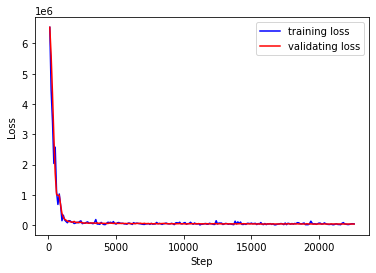

In [25]:
#Plotting loss
pyplot.plot(step_list, train_loss_list, color='blue', label='training loss')
pyplot.plot(step_list, val_loss_list, color='red', label='validating loss')
pyplot.legend()
pyplot.xlabel('Step')
pyplot.ylabel('Loss')
pyplot.show()

## ***5. Testing the performance of the model***





In [26]:
test_losses = [] # track loss
num_correct = 0

ints = []
predictions= []
orig_labels = []

net_lstm = load_model('./save/trained_lstm') #load the saved model

h = net_lstm.init_hidden(batch_size)

net_lstm.eval()

for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    ints.extend(inputs.to('cpu').tolist())

    # get predicted outputs
    output, h = net_lstm(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    pred = torch.round(output.squeeze()/1000)  # rounds to the nearest integer
    original_labels = labels // 1000

    predictions.extend(pred)
    orig_labels.extend(original_labels)
    # compare predictions to true label
    correct_tensor = pred.eq(original_labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    # -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy of LSTM networks: {:.3f}".format(test_acc))

Test loss: 38150.624
Test accuracy of LSTM networks: 0.952


In [27]:
int_to_char = {v: k for k, v in char_to_int.items()}
def convert_ints_to_word(ints):
    word = ''
    for num in ints:
        if num != 0:
            word += int_to_char[num]
    return word

In [28]:
error_list = []
ints = list(ints)
for i in range(len(predictions)):
    if predictions[i] != orig_labels[i]:
        error_word = convert_ints_to_word(ints[i])
        error_list.append("{}\t{}\t{}".format(error_word, orig_labels[i], predictions[i]))

### ***5.1 Print out the words with false predictions***

***Note:*** original labels first

In [29]:
for i in range(len(error_list)):
    print(error_list[i])

giggly	3	2.0
wineberg	2	3.0
alyeska's	3	4.0
minefields	2	3.0
bichler	3	2.0
dieterich	3	4.0
cnet	2	1.0
cacld	2	1.0
rademacher	4	3.0
kouyate	3	2.0
weyenberg	2	3.0
gracias	3	2.0
bachailian	4	3.0
bruinsma	3	2.0
jere	2	1.0
euromobiliare	5	6.0
largeness	2	3.0
coenzyme	3	2.0
hadler	3	2.0
datapower	3	4.0
whomsoever	4	3.0
up	1	2.0
reihl	1	2.0
idealists	3	4.0
wahine	3	2.0
sporophyte	2	3.0
feb	4	1.0
koegler	3	2.0
akao	3	2.0
alves	2	1.0
dsouza	3	2.0
fluor	2	1.0
cordial	2	3.0
souring	3	2.0
asia's	2	3.0
joers	2	1.0
gametangia	5	4.0
reshuffling	4	3.0
zentralsparkasse	5	4.0
aluminosilicate	7	6.0
amelia	3	4.0
kaohsiung	4	3.0
myojin	2	3.0
asia	2	3.0
evidentiary	6	5.0
garcia	3	2.0
livesay	3	2.0
doable	3	2.0
nordine	3	2.0
rovaniemi	5	4.0
lavere	3	2.0
haydn	2	1.0
goering	3	2.0
cevaxs	3	2.0
rahe	2	1.0
allender	4	3.0
dauenhauer	4	3.0
pc's	2	3.0
crippling	3	2.0
reay	1	2.0
heroized	3	2.0
gruet	2	1.0
hours	2	1.0
eduardo	3	4.0
jefferies's	3	4.0
skrzypek	3	2.0
beachler	3	2.0
treml	2	1.0
makegood	2	3.0
hejl	1	2.0


**Note:** it can be seen the errors are acceptable. The differences between predictions and real labels are often `1.0` syllable. I believe this would not affect the final result of the reading level

## ***6. Deploy model***

### ***6.1 On words***

In [30]:
def tokenize_word(words):

  
    test_ints = []
    for word in words:
      word = word.lower()
      test_int = [char_to_int[char] for char in word if char in char_to_int]
      if len(test_int) > 0:
          test_ints.append(test_int)
    test_ints = pad_words(test_ints, 28)
    return test_ints

def predict(net, words):
    
    net.eval()
    

    test_ints = tokenize_word(words)
    print(test_ints)
    

    features = np.array(test_ints)
    

    feature_tensor = torch.from_numpy(features)
    batch_size =  feature_tensor.size(0)
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    pred = torch.round(output.squeeze()/1000)
    print(pred.data) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: ', (output.data))
  

In [31]:
predict(net_lstm, ['moby', 'dick', 'or', 'the', 'whale'])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  14  9 19 21]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  13  6 12 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  9  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0 10 16  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 24
  16  4 11  3]]
tensor([2., 1., 1., 1., 1.], device='cuda:0')
Prediction value, pre-rounding:  tensor([2042.9443, 1031.2249, 1153.6891, 1039.3712, 1013.9448],
       device='cuda:0')


### ***6.2 On text file***